/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


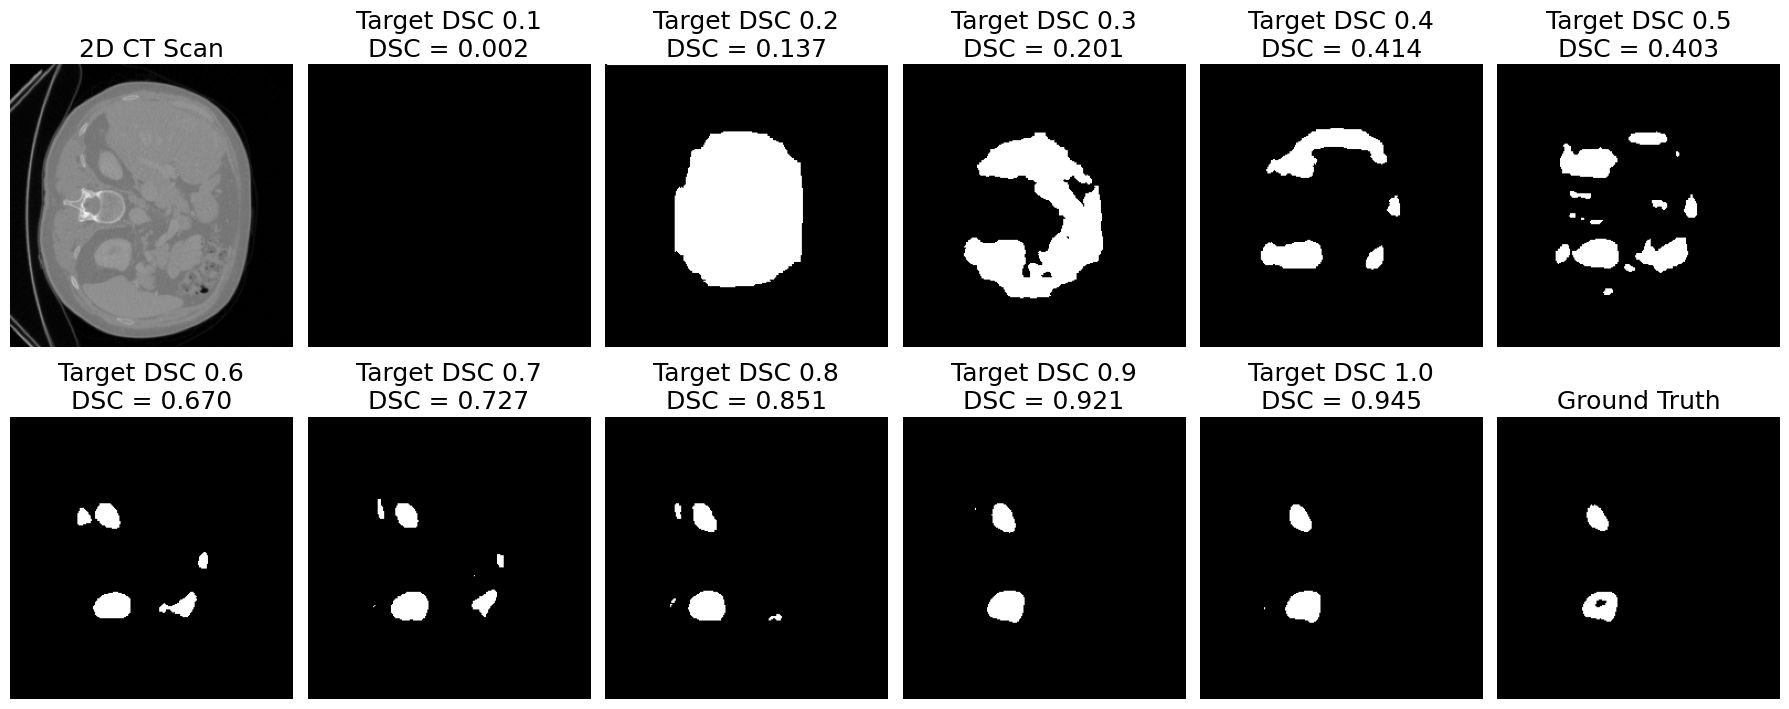

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import functional as TF
from pathlib import Path

# Parameters
case_idx = 13867
slice_dir = Path("/work3/kvabo/PKGCTORG/newCT")
models = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]  

# Load reference to get case/slice
qcData_ref = pd.read_csv("/work3/kvabo/predictions/qcKidneyDsc1.0/results.csv")
case_number = int(qcData_ref.loc[case_idx, "case"])
slice_index = int(qcData_ref.loc[case_idx, "slice"])

# Load CT slice
ct_path = slice_dir / f"volume-{case_number}.npy"
ct = np.load(ct_path)[:, :, slice_index]
ct = Image.fromarray(ct).convert("F")
ct = TF.resize(ct, (256, 256))
ct = np.array(ct, dtype=np.float32)

# Load and resize ground truth
gt_path = slice_dir / f"labels-{case_number}.npy"
gt_full = np.load(gt_path)
gt = (gt_full[:, :, slice_index] == 4).astype(np.uint8)
gt_tensor = torch.tensor(gt).unsqueeze(0).float()
gt_resized = TF.resize(gt_tensor, (256, 256)).squeeze().numpy().astype(np.uint8)

# Create figure grid
n_plots = len(models) + 2  # CT + all models + GT
n_cols = 6
n_rows = int(np.ceil(n_plots / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 4 * n_rows))
axs = axs.flatten()

# Plot CT
axs[0].imshow(ct, cmap='gray')
axs[0].set_title("2D CT Scan", fontsize=18)
axs[0].axis('off')

# Plot predictions
for i, dsc_target in enumerate(models):
    model_tag = f"{dsc_target:.1f}"
    seg_path = Path(f"/work3/kvabo/predictions/qcKidneyDsc{model_tag}/{case_number}_slice_{slice_index}_pred.npy")
    result_path = Path(f"/work3/kvabo/predictions/qcKidneyDsc{model_tag}/results.csv")
    ax = axs[i + 1]

    if seg_path.exists() and result_path.exists():
        pred = np.load(seg_path)

        # Load DSC
        df = pd.read_csv(result_path)
        dsc_val = df[(df["case"] == case_number) & (df["slice"] == slice_index)]["dsc"].values

        if len(dsc_val) > 0:
            dsc = float(dsc_val[0])
            ax.imshow(pred, cmap='gray')
            ax.set_title(f"Target DSC {model_tag}\nDSC = {dsc:.3f}", fontsize=18)
        else:
            ax.text(0.5, 0.5, "DSC not found", ha='center', va='center')
    else:
        ax.text(0.5, 0.5, "Missing", ha='center', va='center')

    ax.axis('off')

# Plot GT
axs[len(models) + 1].imshow(gt_resized, cmap='gray')
axs[len(models) + 1].set_title("Ground Truth", fontsize=18)
axs[len(models) + 1].axis('off')

# Hide any unused subplots
for j in range(n_plots, len(axs)):
    axs[j].axis('off')

#plt.suptitle(f"Segmentations for Case {case_number}, Slice {slice_index}", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.00, 1, 0.95])
plt.savefig(f"kidney_segmentations_case{case_number}_slice{slice_index}.png", dpi=300, bbox_inches='tight')
plt.show()
